# Decision Tree
Decision Tree (Cây quyết định) là thuật toán thường dược dùng cho các bài toán có dữ liệu đầu vào có cấu trúc (structured data), ví dụ như dữ liệu ở dạng bảng (tabular).      
Decision Tree chia nhỏ dataset dựa vào các features để tạo ra các node. Mỗi node biểu diễn một feature, riêng các node lá (leaf node) biểu diễn kết quả dự đoán.    
Ví dụ, chúng ta có bài toán phân loại nấm: Cho đầu vào là màu mũ nấm (cap), hình dáng thân (stalk) và hình thức mọc (solitary hay không). Dự đoán xem nấm có ăn được hay không. Ở đây, mình sẽ chỉ diễn giải các khái niệm, intuition và implementation để tạo nên cây quyết định, sau đó mới sử dụng hàm có sẵn trong Tensorflow.        
![dataset](dataset.png#center "dataset")

In [13]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Initialize dataset
X_train = np.array([[1,1,1],[1,0,1],[1,0,0],[1,0,0],[1,1,1],[0,1,1],[0,0,0],[1,0,1],[0,1,0],[1,0,0]])
y_train = np.array([1,1,0,0,1,0,0,1,1,0])

## Entropy
Để tạo Decision Tree, trước hết chúng ta cần hiểu về khái niệm entropy. **Entropy là đại lượng đặc trưng cho mức độ không đồng nhất trong một dataset.** Khi dữ liệu trong dataset đều cùng 1 class, entropy = 0. Khi dữ liệu phân bố đều nhau, entropy = 1.      
Ví dụ, tất cả nấm trong dataset đều có mũ nàu nâu, tức là dataset hoàn toàn thuần khiết (pure) $\rightarrow$ Entropy = 0.   
Trái lại, một nửa số nấm trong dataset có mũ màu đỏ và một nửa còn lại có mũ màu nâu, tức là dataset hỗn loạn nhất (impure), không có xu hướng rõ ràng $\rightarrow$ Entropy = 1.
1. Công thức
$$H(D) = -\sum_{i=1}^{k}p_{i}log_{2}{p_{i}}$$
Trong đó:      
$p_{i}$ là xác suất class $i$ xuất hiện trong dataset $D$       
$k$ là số class        
Để thuận tiện cho tính toán, người ta quy ước $0log_{2}0=0$    
2. Đồ thị entropy

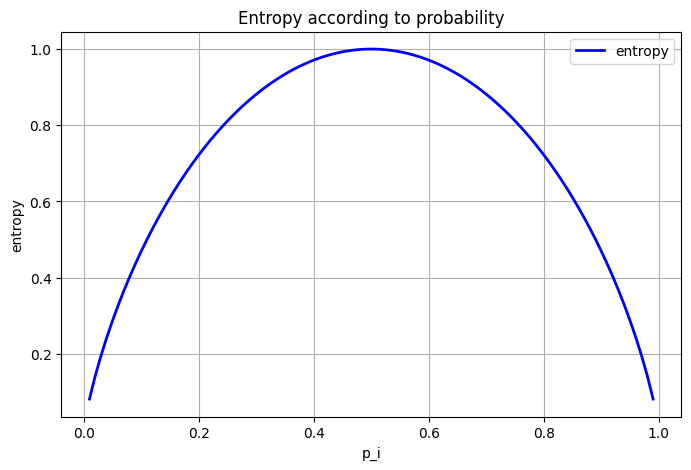

In [15]:
# Create probability values from 0 to 1
p = np.linspace(0.01, 0.99, 100)  # to avoid log(0)
entropy_ = -p * np.log2(p) - (1 - p) * np.log2(1 - p)

plt.figure(figsize=(8, 5))
plt.plot(p, entropy_, label='entropy', color='blue', linewidth=2)
plt.xlabel('p_i')
plt.ylabel('entropy')
plt.title('Entropy according to probability')
plt.legend()
plt.grid(True)

plt.show()

In [16]:
def compute_entropy(y):
    """
    Computes the entropy for 
    
    Args:
       y (ndarray): Numpy array indicating whether each example at a node is
           edible (`1`) or poisonous (`0`)
       
    Returns:
        entropy (float): Entropy at that node
        
    """
    entropy = 0.
    
    if len(y) == 0:
        return 0
    else:
        p = sum(y)/len(y)
        if p == 0 or p == 1:
            entropy = 0
        else:
            entropy = -p * np.log2(p) - (1-p) * np.log2(1-p)

    return entropy

## Information Gain
Chúng ta muốn chia dataset theo từng feature thành các tập nhỏ hơn để phân loại chúng. Để chọn được feature phù hợp để split, ta split làm sao để weighted average entropy của các node mới giảm nhiều nhất so với root node. **Information gain (IG) chính là độ giảm entropy của child node so với parent node**. Để dễ hiểu hơn, mình sẽ minh họa cách split với dataset về nấm ở trên nhé.      
Ta có 10 loài nấm, trong đó có 5 loài ăn được và 5 loài không ăn được. Ta cần classify các loài ăn được.
- Entropy tại root node: $H(p_{root})=H(\frac{5}{10})=1$          
Để chọn được feature phù hợp cho việc split, chúng ta so sánh độ giảm entropy (chính là IG) khi chia dữ liệu theo từng feature, rồi chọn feature nào làm IG lớn nhất.              
         
![information-gain](split.png)

- IG of "Brown Cap" feature:       
$H(p_{root}) - \frac{4}{10} H(\frac{4}{7}) - \frac{1}{10} H(\frac{1}{3}) = 1 - (\frac{4}{10} \times 0.46 + \frac{1}{10} \times 0.53) = 0.76$ 
          
- IG of "Tapering stalk" feature:       
$H(p_{root}) - \frac{3}{10} H(\frac{3}{4}) - \frac{2}{10} H(\frac{2}{6}) = 1 - (\frac{4}{10} \times 0.0.31 + \frac{1}{10} \times 0.53) = 0.80$   
     
- IG of "Solidary" feature:       
$H(p_{root}) - \frac{4}{10} H(\frac{4}{5}) - \frac{1}{10} H(\frac{1}{5}) = 1 - (\frac{4}{10} \times 0.26 + \frac{1}{10} \times 0.46) = 0.85$
         
Ta thấy feature "Solidary" có độ giảm entropy cao nhất nên chọn split dataset theo feature này đầu tiên.            
Dưới đây lần lượt là 3 hàm để split dataset theo feature, tính information gain, và chọn feature phù hợp nhất để split (có information gain cao nhất).               


In [17]:
def split_dataset(X, node_indices, feature):
    """
    Splits the data at the given node into
    left and right branches
    
    Args:
        X (ndarray):             Data matrix of shape(n_samples, n_features)
        node_indices (list):     List containing the active indices. I.e, the samples being considered at this step.
        feature (int):           Index of feature to split on
    
    Returns:
        left_indices (list):     Indices with feature value == 1
        right_indices (list):    Indices with feature value == 0
    """
    left_indices = []
    right_indices = []
    
    for i in node_indices:
        if X[i][feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    return left_indices, right_indices

In [18]:
def compute_information_gain(X, y, node_indices, feature):
    
    """
    Compute the information of splitting the node on a given feature
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        feature (int):           Index of feature to split on
   
    Returns:
        cost (float):        Cost computed
    
    """    
    # Split dataset
    left_indices, right_indices = split_dataset(X, node_indices, feature)
    
    # Some useful variables
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    information_gain = 0
    
    w_left = len(X_left)/len(X_node)
    w_right = len(X_right)/len(X_node)

    H_node, H_left, H_right = compute_entropy(y_node), compute_entropy(y_left), compute_entropy(y_right)
    
    information_gain = H_node - (w_left * H_left + w_right * H_right)
    
    return information_gain

In [19]:
def get_best_split(X, y, node_indices):   
    """
    Returns the optimal feature and threshold value
    to split the node data 
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.

    Returns:
        best_feature (int):     The index of the best feature to split
    """    
    
    # Some useful variables
    num_features = X.shape[1]

    best_feature = -1

    max_info_gain = 0
    
    for feature in range(num_features):
        info_gain = compute_information_gain(X, y, node_indices, feature)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_feature = feature 
   
    return best_feature

Đặt index của các feature "Brown Cap", "Tapering Stalk" và "Solidary" lần lượt là 0, 1, 2. Ở trên, chúng ta đã tìm được best feature để split là "Solidary", tức là feature 2. Thử kiểm chứng lại nhé.       

In [20]:
root_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
best_feature = get_best_split(X_train, y_train, root_indices)
print("Best feature to split: ", best_feature)

Best feature to split:  2


Cuối cùng, chúng ta có thể tạo cây quyết định bằng cách đệ quy (recursion). Lặp lại các bước:
- Tính information gain với mỗi cách split
- Chọn best feature to split
- Split         
cho tới khi cây thỏa mãn điều kiện dừng. Điều kiện dừng có thể là khi cây đạt độ sâu tối đa (max_depth như dưới), khi information gain không cải thiện, hoặc khi tất cả samples tại mỗi node đều thuộc 1 class.     

In [21]:
tree = []

def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth):
    """
    Build a tree using the recursive algorithm that split the dataset into 2 subgroups at each node.
    This function just prints the tree.
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        branch_name (string):   Name of the branch. ['Root', 'Left', 'Right']
        max_depth (int):        Max depth of the resulting tree. 
        current_depth (int):    Current depth. Parameter used during recursive call.
   
    """ 

    # Maximum depth reached - stop splitting
    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return
   
    # Otherwise, get best split and split the data
    # Get the best feature and threshold at this node
    best_feature = get_best_split(X, y, node_indices) 
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))
    
    # Split the dataset at the best feature
    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))
    
    # continue splitting the left and the right child. Increment current depth
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1)

In [22]:
build_tree_recursive(X_train, y_train, root_indices, "Root", max_depth=2, current_depth=0)

 Depth 0, Root: Split on feature: 2
- Depth 1, Left: Split on feature: 0
  -- Left leaf node with indices [0, 1, 4, 7]
  -- Right leaf node with indices [5]
- Depth 1, Right: Split on feature: 1
  -- Left leaf node with indices [8]
  -- Right leaf node with indices [2, 3, 6, 9]


Cây quyết định cuối cùng có dạng như sau:
![final-tree](final_tree.png)

# Random Forest
Thuật toán Random Forest là một mô hình tree ensemble, kết hợp nhiều cây quyết định thay vì chỉ 1 cây, giúp đưa ra dự đoán chính xác hơn và giảm khả năng overfitting.       
Thuật toán này sẽ chọn ra các tập con từ dataset ban đầu bằng phương pháp "sampling with replacement". Mỗi tập con sẽ được dùng để train 1 cây. Với mỗi cây, chọn ra $k$ features trong số $n$ features thay vì chọn tất cả. Kết quả dự đoán đối với bài toán **classification** được xác định bằng cách cho các cây vote, đối với bài toán **regression** là trung bình dự đoán của các cây.       
Mình sẽ sử dụng Random Forest cho bài toán phân loại nấm ở folder Practice.

**Tóm tắt kiến thức đã học:
- Entropy: compute_entropy(y)
- Information gain: compute_information_gain(X, y, node_indices, feature)
- Split dataset: split_dataset(X, node_indices, feature)
- Get best split: get_best_split(X, y, node_indices)
- Tạo cây sử dụng recursion